In [1]:
%load_ext autoreload
%autoreload 2
import json
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import experiments
import utils
from granularity import *
import experiment_manager as mngr

In [2]:
bbexp = mngr.BBExperiment()
bbexp.setup(skip_gran=True)

100%|██████████| 200/200 [00:08<00:00, 24.00it/s]


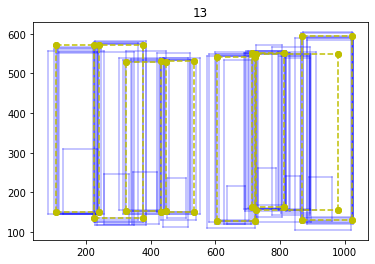

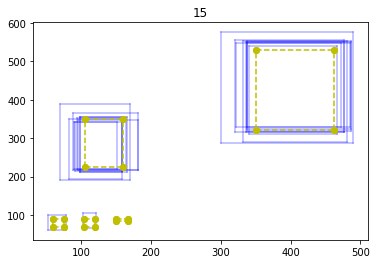

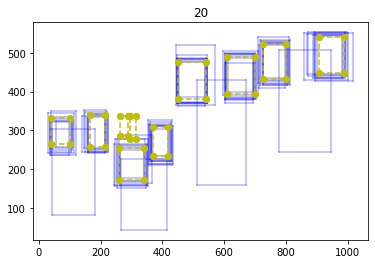

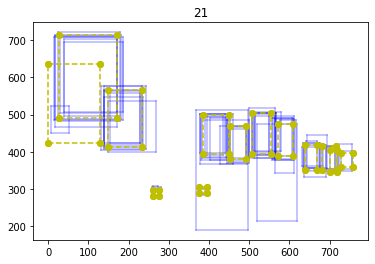

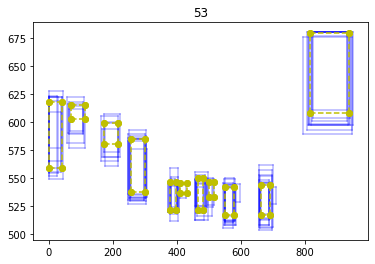

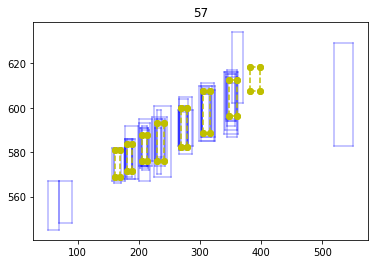

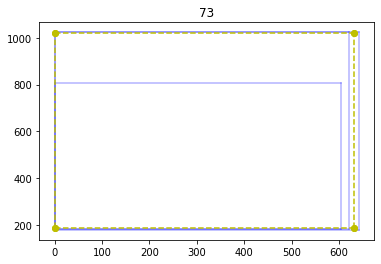

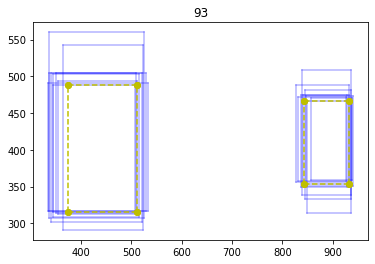

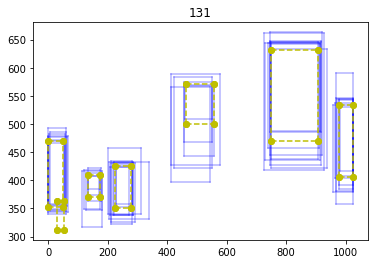

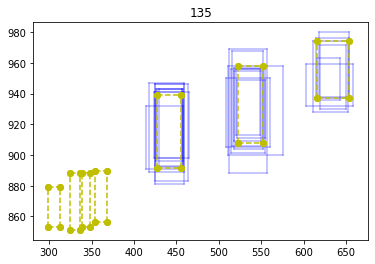

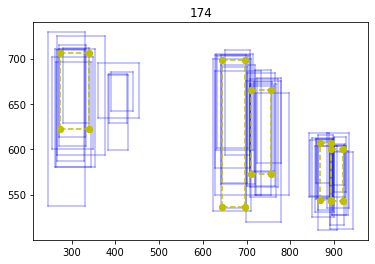

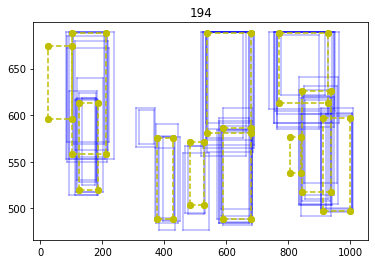

""


In [3]:
def plot_vectorrange(vr, color="b", alpha=0.3):
    plt.plot([vr.start_vector[0], vr.end_vector[0]], [vr.start_vector[1], vr.start_vector[1]], color, alpha=alpha)
    plt.plot([vr.start_vector[0], vr.start_vector[0]], [vr.start_vector[1], vr.end_vector[1]], color, alpha=alpha)
    plt.plot([vr.start_vector[0], vr.end_vector[0]], [vr.end_vector[1], vr.end_vector[1]], color, alpha=alpha)
    plt.plot([vr.end_vector[0], vr.end_vector[0]], [vr.start_vector[1], vr.end_vector[1]], color, alpha=alpha)

def plot_annos(data, expmnt):
    vrs = [vr for annotation in data["annotation"] for vr in annotation]
    for vr in vrs:
        plot_vectorrange(vr)
    item = data["item"].values[0]
    try:
        for gvr in expmnt.golddict.get(item):
            plot_vectorrange(gvr, "yo--", alpha=1)
    except:
        pass
    plt.title(data["item"].values[0])
    plt.show()

bbexp.annodf.iloc[:100].groupby("item").apply(plot_annos, bbexp)


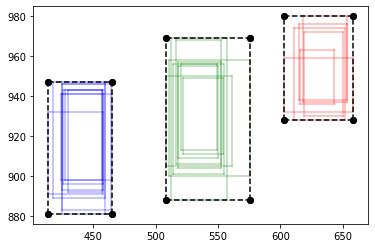

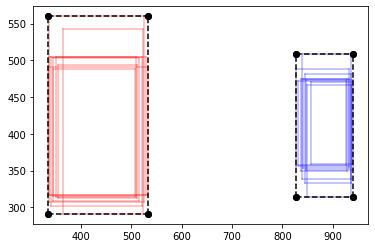

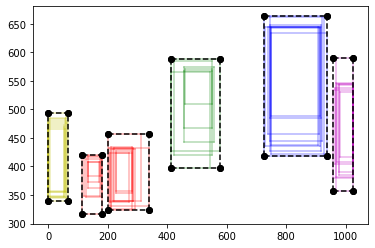

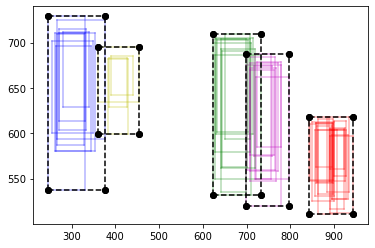

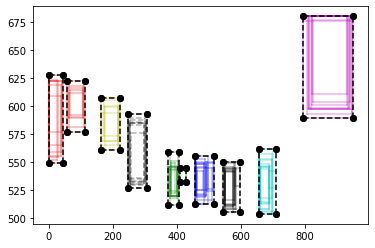

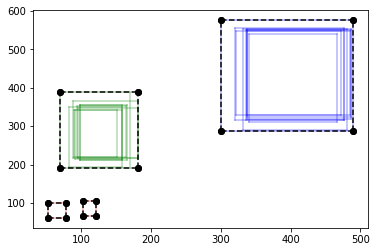

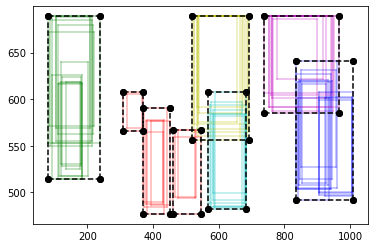

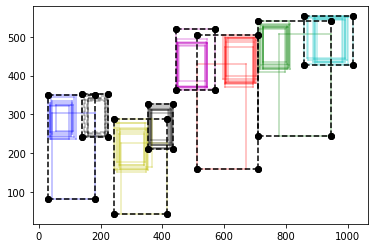

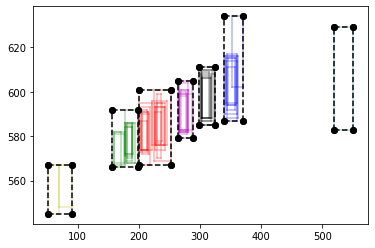

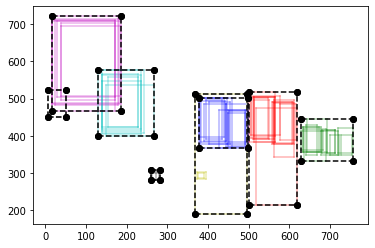

[2 0 0 7 3 9 5 4 2 0 0 7 3 9 5 4 4 5 9 3 2 0 0 7 8 6 6 6 1 1 1 2 2 0 0 7 3
 9 5 4 2 0 0 7 3 9 5 4 4 5 9 3 2 0 0 7 3 9 5 4]
list index out of range


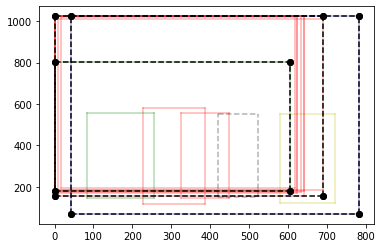

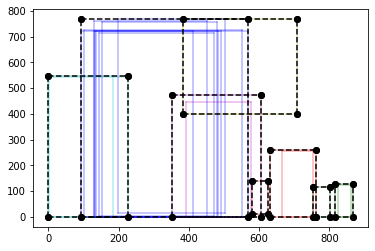

[5 6 4 7 2 8 1 5 7 2 1 0 4 5 4 6 0 8 1 1 2 3 7 0 7 2 6 5 4 5 4 6 7 2 1 1 8
 0 3 5 7 1 8 3 2 1 6 0 4 5 4 6 0 8 1 1 2 3 7 3 7]
list index out of range


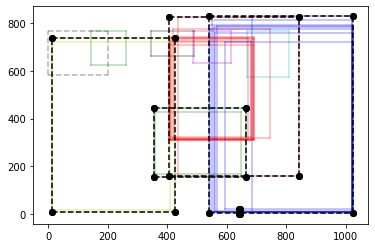

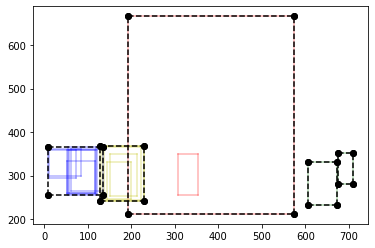

[3 2 5 8 0 1 3 7 0 4 1 6 0 4 3 2 1 3 3 7 0 0 4 7 3 1 3 7 1 4 0 3 7 0 4 1 3
 7 4 0]
list index out of range


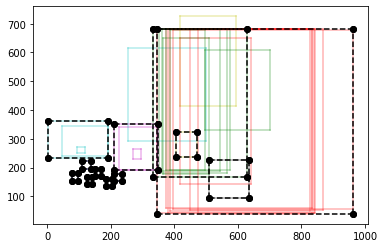

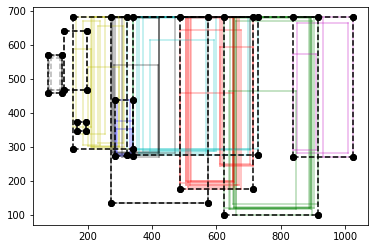

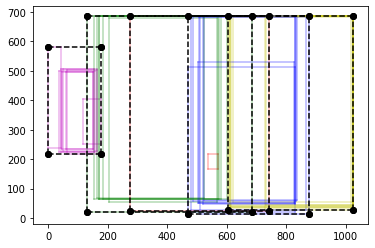

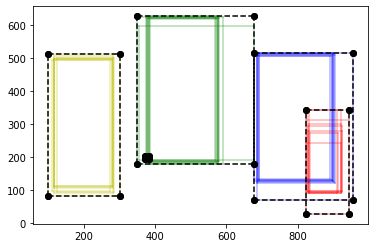

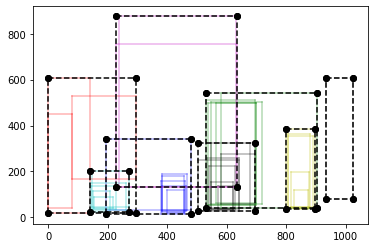

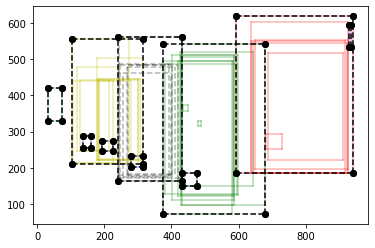

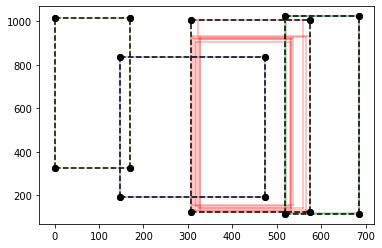

[7 8 2 1 0 3 6 5 6 7 2 8 1 0 3 4 5 0 1 2 8 6 7 5 6 4 1 0 2 8 7 5 6 7 8 2 1
 4 0 8 7 8 2 1 0 4 6 5 8 7 6 2 1 5 0 4 3 6 7 8 2 9 1 1 5 0 0 4]
list index out of range


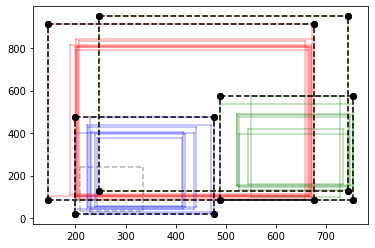

TypeError: 'NoneType' object is not iterable

In [268]:
from collections import defaultdict
import sklearn
from sklearn.cluster import AgglomerativeClustering, DBSCAN, OPTICS
from sklearn.metrics.pairwise import euclidean_distances
from eval_functions import _iou_score

item = {}

def test_decomp_fn(vectorranges, use_centroids=True):

    if use_centroids:
        centroids = [vr.centroid() for vr in vectorranges]
        dists = euclidean_distances(centroids)
        mean_dist = np.std(dists)
        clustering = AgglomerativeClustering(n_clusters=None,
                                             distance_threshold=mean_dist)
        clustering.fit(centroids)
    else:
        dists = np.array([[1 - _iou_score(a, b) for a in vectorranges] for b in vectorranges])
        mean_dist = np.std(dists)
        clustering = AgglomerativeClustering(n_clusters=None,
                                             distance_threshold=mean_dist,
                                             affinity="precomputed",
                                             linkage="average")
        clustering.fit(dists)
        
    labels = clustering.labels_
    labeldict = defaultdict(list)
    for i, label in enumerate(labels):
        labeldict[label].append(i)
    result = []
    for indices in labeldict.values():
        uv = unionize_vectorrange_sequence(np.array(vectorranges)[np.array(indices)])
        result += uv
    
    colors = ["r", "b", "g", "y", "m", "c", "k", "k--"]
    try:
        for i, vr in enumerate(vectorranges):
            plot_vectorrange(vr, color=colors[labels[i]])
        for vr in result:
            plot_vectorrange(vr, color="ko--", alpha=1)
        plt.show()
    except Exception as e:
        print(labels)
        print(e)
        pass
    item[str(mean_dist)] = 1
    if len(item.keys()) <= 25:
        return result

granno_df = fragment_by_overlaps(bbexp, decomp_fn=test_decomp_fn)

In [12]:
np.random.seed(42)
with open('data/gt_canary_od_pretty_02042020.json') as f:
    dataset = json.load(f)

In [13]:
cols = ["item", "uid", "annotation", "groundtruth"]

NUM_ITEMS = 200
MAX_WORKERS_PER_ITEM = 4
i = 0
rows = []
for image_key, all_data in dataset.items():
    i+=1
    if i > NUM_ITEMS:
        break
    raw_annotations_dict = all_data['worker_answers']
    gt = all_data['ground_truth']['annotations']
    keys =  list(raw_annotations_dict.keys())
    random.shuffle(keys)
    
    for worker_id in keys[:MAX_WORKERS_PER_ITEM]:
        anno = raw_annotations_dict[worker_id]
        stripped_anno = anno['answerContent']['boundingBox']['boundingBoxes']                                                      
        row = [image_key, worker_id, stripped_anno, gt]
        rows.append(row)
tmpdf = pd.DataFrame(rows, columns=cols)

In [14]:
df = tmpdf

In [15]:
def convert2vr(annotations):
    result = []
    for annotation in annotations:
        left = annotation["left"]
        top = annotation["top"]
        if annotation["width"] > 0 and annotation["height"] > 0:
            result.append(VectorRange([left, top], [left + annotation["width"], top + annotation["height"]]))
        else:
            return np.nan
    return result

if "raw_labels" not in df.columns:
    df["raw_labels"] = df["annotation"]
if "raw_gold" not in df.columns:
    df["raw_gold"] = df["groundtruth"]
    
df["annotation"] = df["raw_labels"].apply(convert2vr).dropna()
df["groundtruth"] = df["raw_gold"].apply(convert2vr).dropna()

In [16]:
def iou_score(vrA, vrB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(vrA.start_vector[0], vrB.start_vector[0])
    yA = max(vrA.start_vector[1], vrB.start_vector[1])
    xB = min(vrA.end_vector[0], vrB.end_vector[0])
    yB = min(vrA.end_vector[1], vrB.end_vector[1])

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (vrA.end_vector[0] - vrA.start_vector[0] + 1) * (vrA.end_vector[1] - vrA.start_vector[1] + 1)
    boxBArea = (vrB.end_vector[0] - vrB.start_vector[0] + 1) * (vrB.end_vector[1] - vrB.start_vector[1] + 1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou



def iou_score_multi(vrAs, vrBs):
    scoresA = [np.max([iou_score(vrA, vrB) for vrB in vrBs] + [0]) for vrA in vrAs]
    scoresB = [np.max([iou_score(vrA, vrB) for vrA in vrAs] + [0]) for vrB in vrBs]
    score = np.mean(scoresA + scoresB)
    return 0 if np.isnan(score) else score


In [17]:
bb_experiment = experiments.RealExperiment(eval_fn=iou_score_multi,label_colname="annotation",
                                                    item_colname="item", uid_colname="uid")

bb_experiment.setup(annodf=df, golddf=df, c_gold_item="item", c_gold_label="groundtruth")

100%|██████████| 199/199 [00:01<00:00, 106.13it/s]


In [19]:
import granularity
def vectorrange_merge_fn(annotations, weights=None): # TODO weights
    non_empty = []
    non_empty_wgts = []
    for i in range(len(annotations)):
        anno = annotations[i]
        if len(anno) > 0:
            non_empty.append(anno)
            non_empty_wgts.append(weights[i])
    frac_non_empty = sum(non_empty_wgts) / sum(weights)
    
    # if majority of annotations are empty, return empty
    if frac_non_empty < 0.5:
        return []
    else:
        sum_start = 0
        sum_end = 0
        sum_wgt = 0
        for annotation, weight in zip(non_empty, non_empty_wgts):
            umeanstart = np.array([vr.start_vector for vr in annotation]).mean(axis=0)
            umeanend = np.array([vr.end_vector for vr in annotation]).mean(axis=0)
            sum_start += umeanstart * weight
            sum_end += umeanend * weight
            sum_wgt += weight
        start = np.round(sum_start / sum_wgt).astype(int)
        end = np.round(sum_end / sum_wgt).astype(int)
        
        if len(start) == 1:
            return [granularity.SeqRange((start[0], end[0]))]
        else:
            return [granularity.VectorRange(start, end)]
        
mergedtmp = bb_experiment.weighted_merge(vectorrange_merge_fn)
mergedtmp

item
0      [([220, 199], [546, 363])]
1      [([526, 555], [671, 731])]
2      [([458, 299], [673, 684])]
3      [([580, 155], [621, 208])]
4      [([503, 122], [575, 215])]
                  ...            
194    [([270, 143], [652, 665])]
195    [([305, 380], [544, 635])]
196    [([594, 202], [638, 265])]
197    [([411, 297], [560, 717])]
198    [([263, 241], [454, 581])]
Length: 199, dtype: object

In [20]:
bb_experiment.annodf.sort_values("item")

,uid,item,annotation
608,153,0,"[([235.0, 202.0], [540.0, 355.0])]"
611,10,0,"[([205.0, 205.0], [548.0, 366.0])]"
610,55,0,"[([224.0, 199.0], [546.0, 354.0])]"
609,151,0,"[([218.0, 190.0], [552.0, 376.0])]"
567,18,1,"[([792.0, 490.0], [995.0, 737.0]), ([397.0, 58..."
...,...,...,...
663,44,197,"[([665.0, 299.0], [880.0, 768.0]), ([610.0, 27..."
655,136,198,"[([367.0, 236.0], [555.0, 572.0]), ([318.0, 48..."
654,97,198,"[([371.0, 211.0], [644.0, 591.0])]"
652,153,198,"[([3.0, 44.0], [101.0, 484.0]), ([372.0, 244.0..."


In [179]:
def merge_mean(annotations):
    vrs = [vr for annotation in annotations for vr in annotation]
    mean_start = np.array([vr.start_vector for vr in vrs]).mean(axis=0)
    mean_end = np.array([vr.end_vector for vr in vrs]).mean(axis=0)
    return [VectorRange(mean_start, mean_end)]

mean_preds = bb_experiment.annodf.groupby("item").agg({"annotation":merge_mean})["annotation"].to_dict()
bb_experiment.register_baseline("MEAN MERGE", mean_preds)


In [180]:
bb_experiment.train(iter=0)
bb_experiment.test(debug=False)
# bb_experiment.debug(plot_vs_gold=True, skip_miniplots=True)

Pickled model loaded
BEST AVAILABLE USER
0.5725106002025941 0.6478674335488478
t-test Ttest_relResult(statistic=-13.102480595393905, pvalue=2.6027481218193495e-36)
z-score 0.41454414071033624
baseline below thresh 0.0
model below thresh 0.0
SMALLEST AVERAGE DISTANCE
0.5725106002025941 0.6654911488712765
t-test Ttest_relResult(statistic=-17.271168712318897, pvalue=1.0969908928966314e-58)
z-score 0.5464355959762623
baseline below thresh 0.0
model below thresh 0.0
HEURISTIC
0.5725106002025941 0.6675550538645012
t-test Ttest_relResult(statistic=-17.812797841150342, pvalue=7.508160960624522e-62)
z-score 0.5635719832550233
baseline below thresh 0.0
model below thresh 0.0
MEAN MERGE
0.5725106002025941 0.18242194098124412
t-test Ttest_relResult(statistic=52.014827416235526, pvalue=1.479721504546428e-286)
z-score -1.6456763113268749
baseline below thresh 0.0
model below thresh 0.0
ORACLE
0.5725106002025941 0.745156316020659
t-test Ttest_relResult(statistic=-33.50078195375674, pvalue=1.530669788

In [236]:
bb_experiment.annodf

,uid,item,annotation
0,97,135,"[([603.0, 932.0], [658.0, 959.0]), ([508.0, 90..."
1,178,135,"[([427.0, 898.0], [457.0, 943.0]), ([518.0, 90..."
2,126,135,"[([418.0, 889.0], [459.0, 947.0]), ([516.0, 90..."
3,157,135,"[([426.0, 896.0], [458.0, 943.0]), ([520.0, 91..."
4,119,135,"[([425.0, 893.0], [458.0, 941.0]), ([518.0, 90..."
...,...,...,...
1794,73,122,"[([22.0, 365.0], [125.0, 497.0]), ([198.0, 273..."
1795,141,122,"[([51.0, 379.0], [116.0, 488.0]), ([203.0, 279..."
1796,167,122,"[([483.0, 295.0], [533.0, 365.0]), ([713.0, 28..."
1797,136,122,"[([32.0, 358.0], [126.0, 509.0]), ([56.0, 286...."


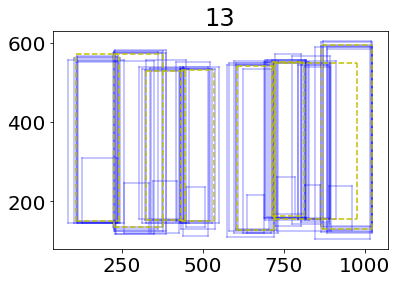

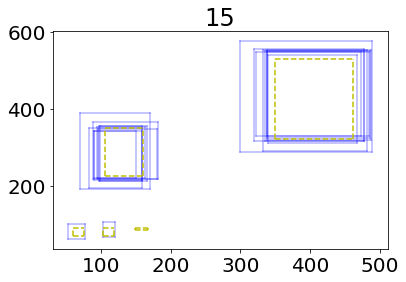

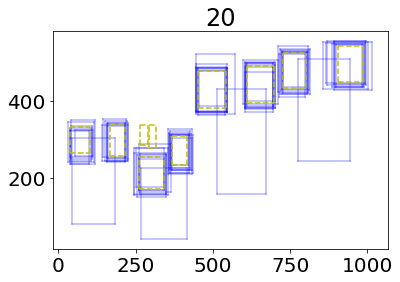

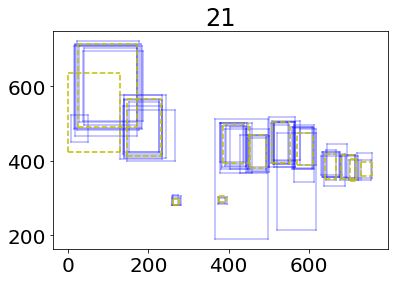

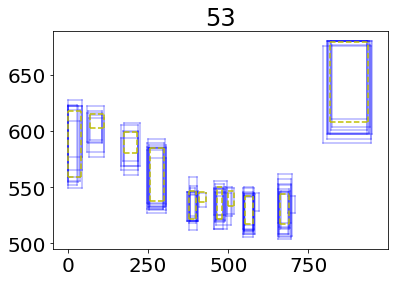

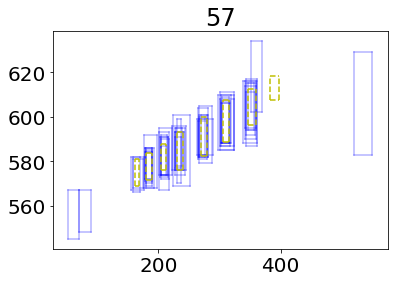

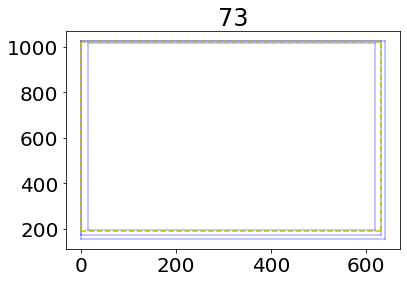

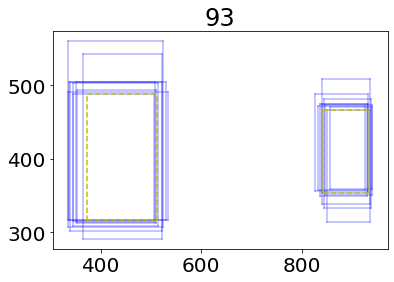

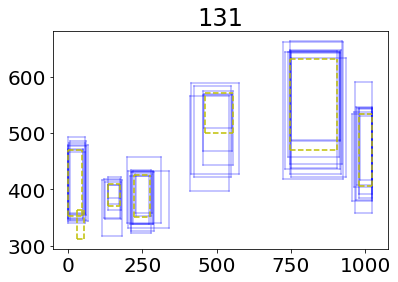

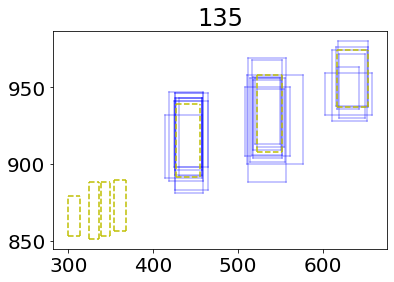

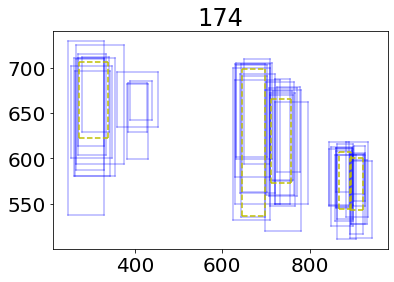

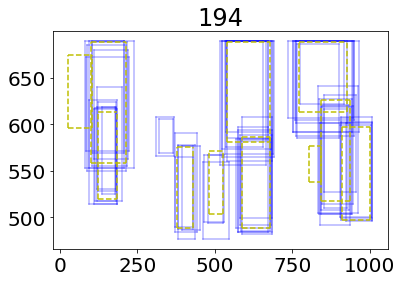

""


In [224]:
def plot_vectorrange(vr, color="b", alpha=0.3):
    plt.plot([vr.start_vector[0], vr.end_vector[0]], [vr.start_vector[1], vr.start_vector[1]], color, alpha=alpha)
    plt.plot([vr.start_vector[0], vr.start_vector[0]], [vr.start_vector[1], vr.end_vector[1]], color, alpha=alpha)
    plt.plot([vr.start_vector[0], vr.end_vector[0]], [vr.end_vector[1], vr.end_vector[1]], color, alpha=alpha)
    plt.plot([vr.end_vector[0], vr.end_vector[0]], [vr.start_vector[1], vr.end_vector[1]], color, alpha=alpha)

def plot_annos(data):
    vrs = [vr for annotation in data["annotation"] for vr in annotation]
    for vr in vrs:
        plot_vectorrange(vr)
    item = data["item"].values[0]
    try:
        for gvr in bb_experiment.golddict.get(item):
            plot_vectorrange(gvr, "y--", alpha=1)
    except:
        pass
    plt.title(data["item"].values[0])
    plt.show()

bb_experiment.annodf.iloc[:100].groupby("item").apply(plot_annos)
    


In [255]:
granno_df = fragment_by_overlaps(bb_experiment.annodf)
granno_df_orc = fragment_by_overlaps(bb_experiment.annodf, oracle_golddict=bb_experiment.golddict)

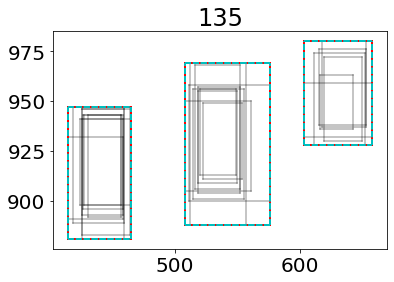

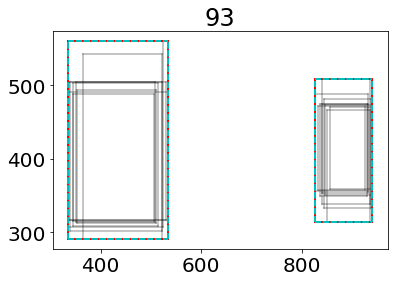

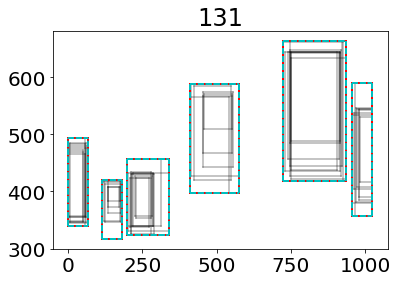

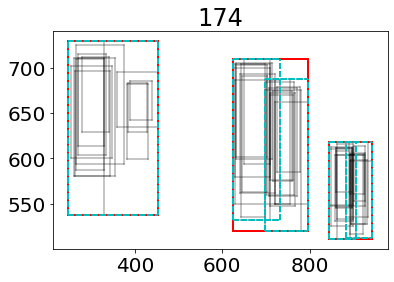

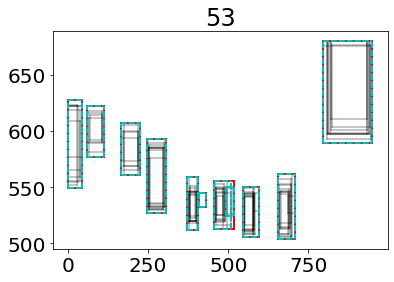

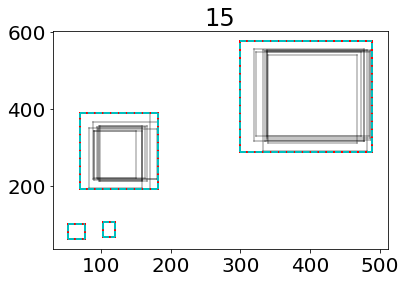

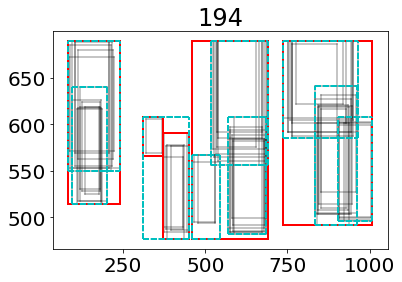

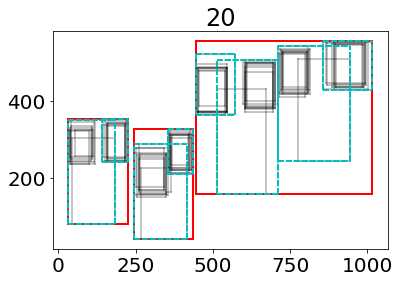

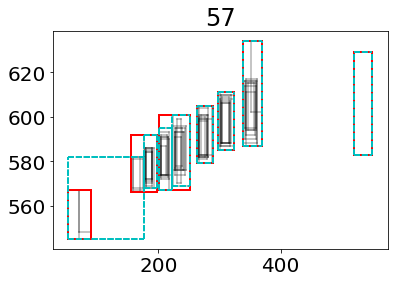

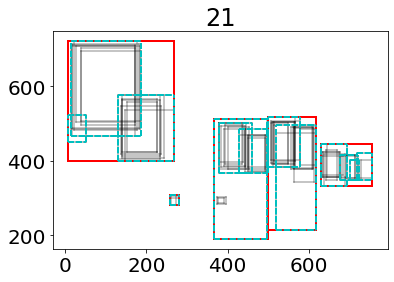

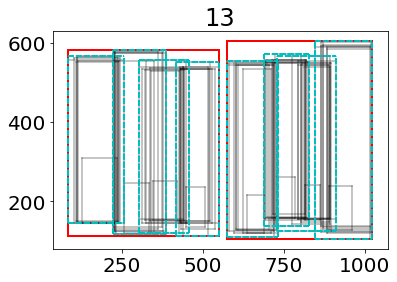

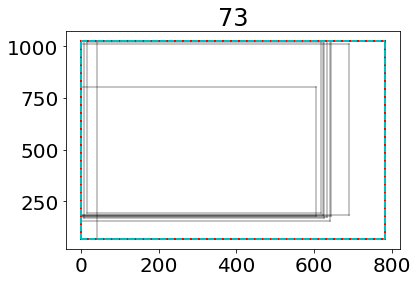

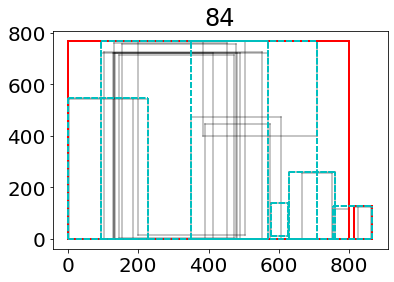

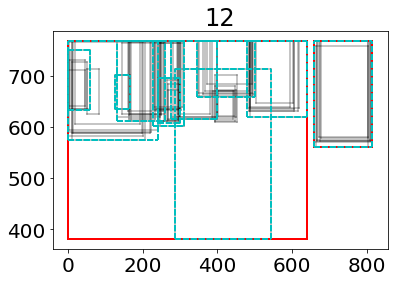

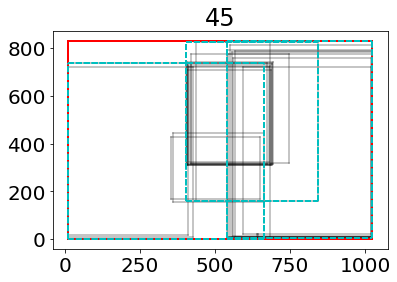

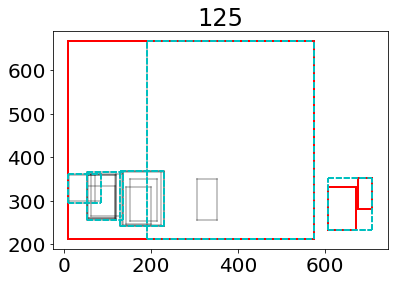

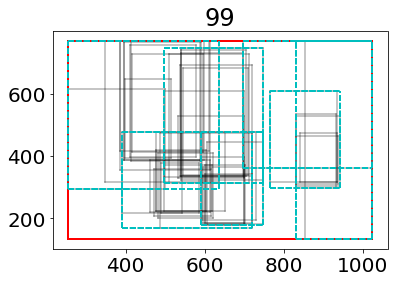

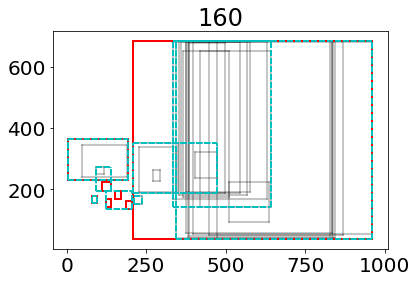

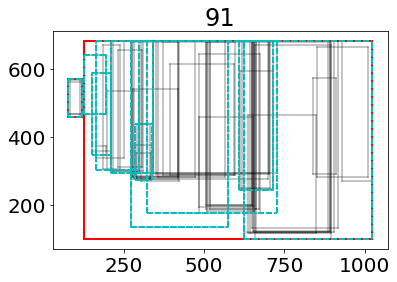

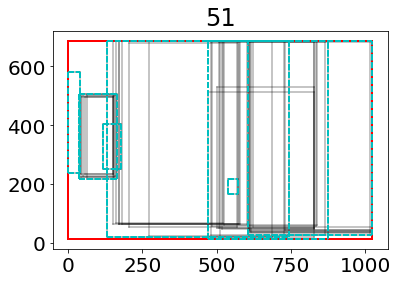

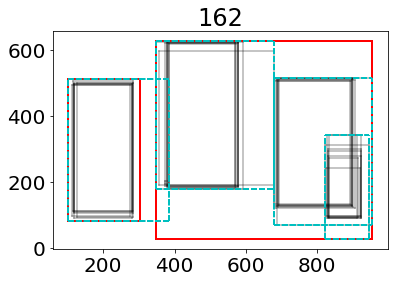

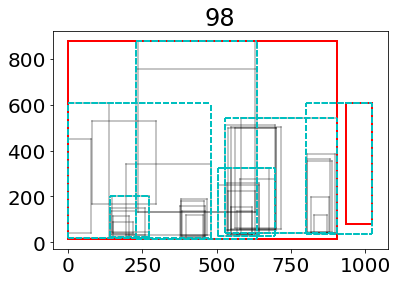

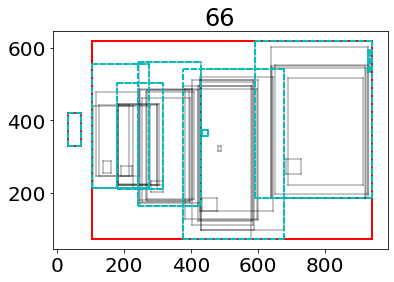

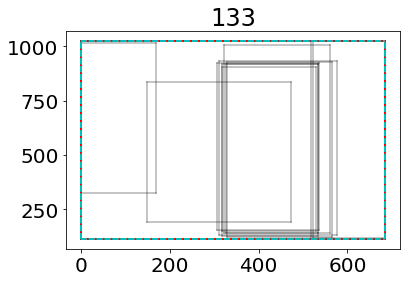

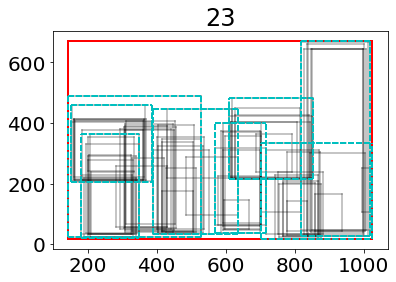

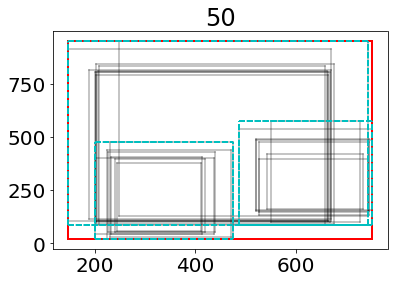

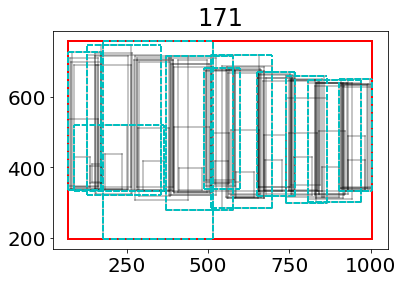

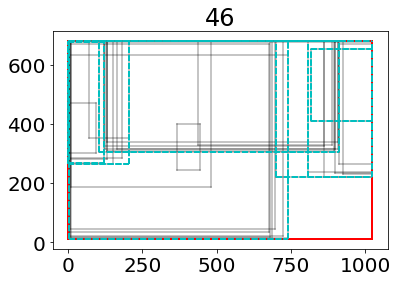

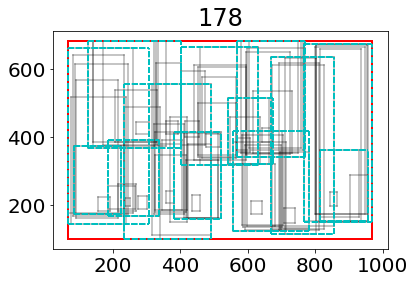

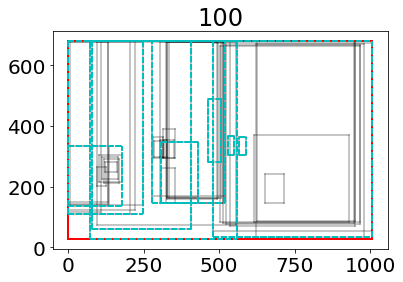

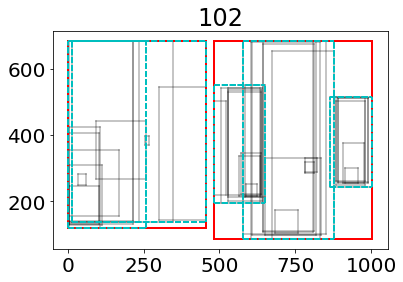

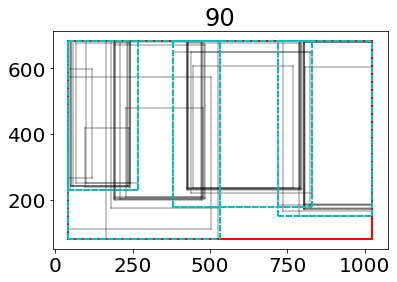

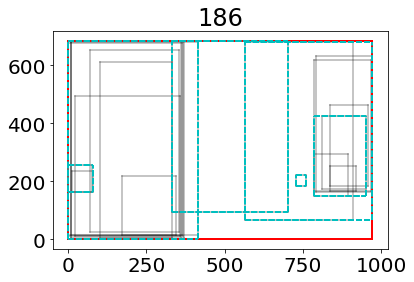

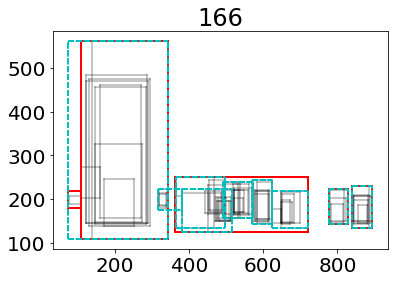

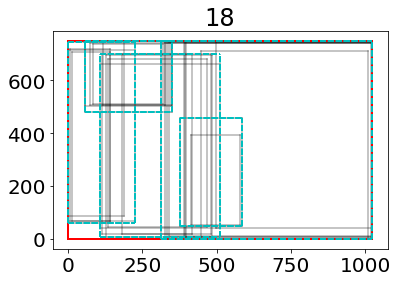

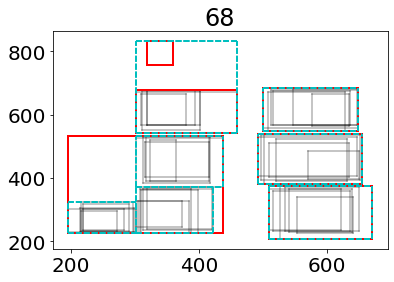

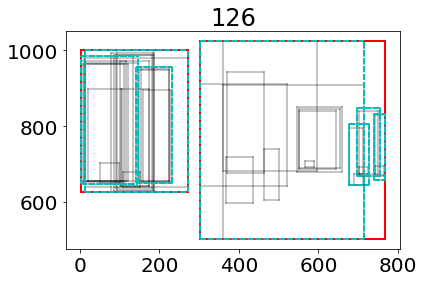

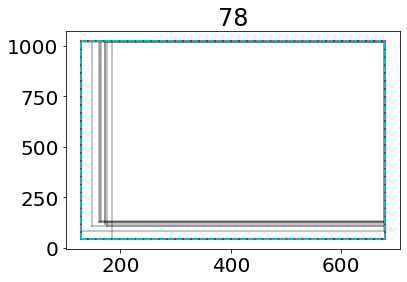

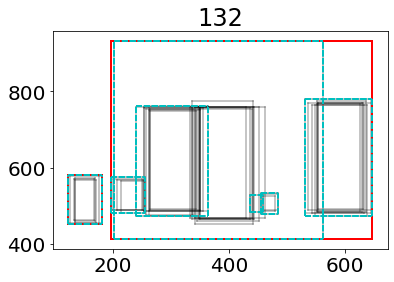

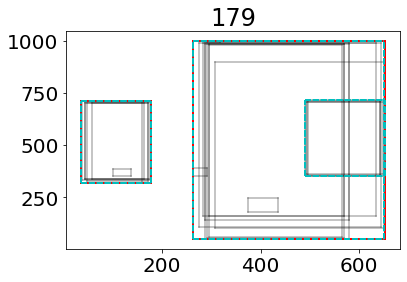

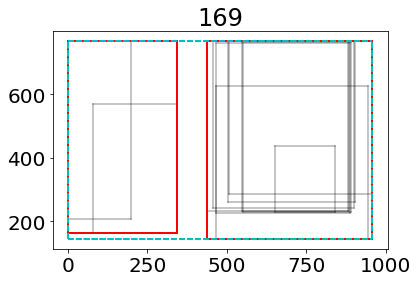

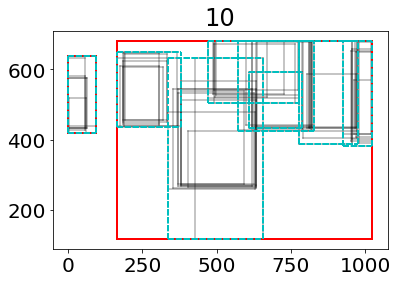

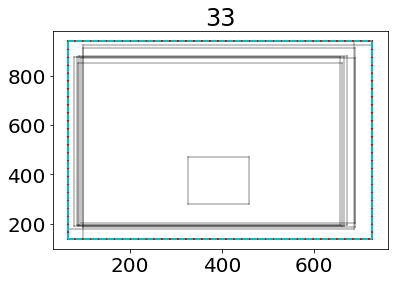

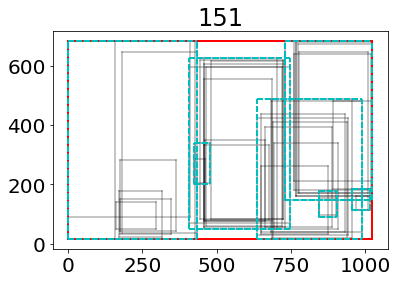

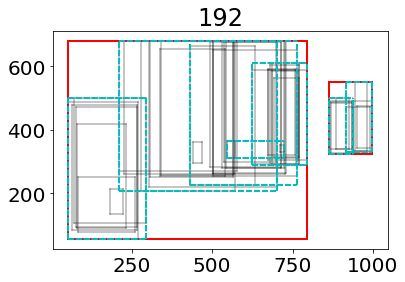

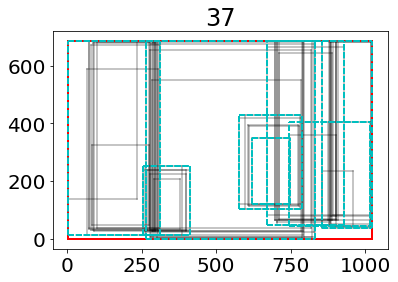

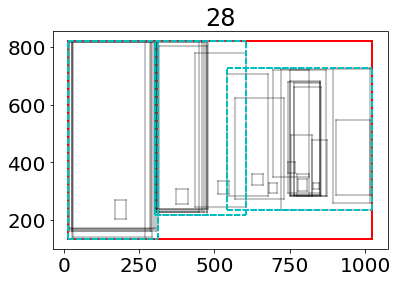

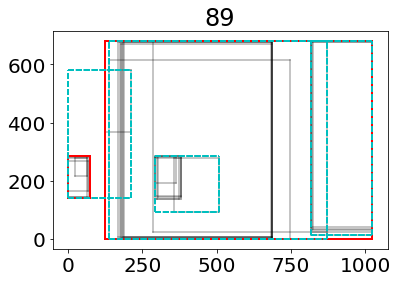

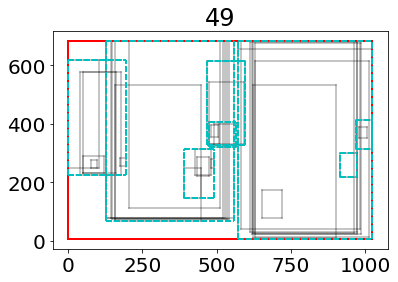

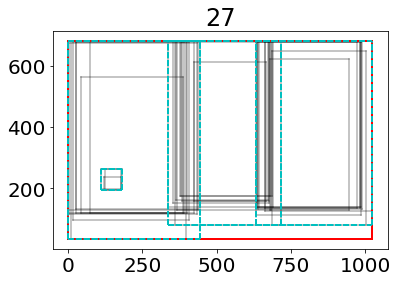

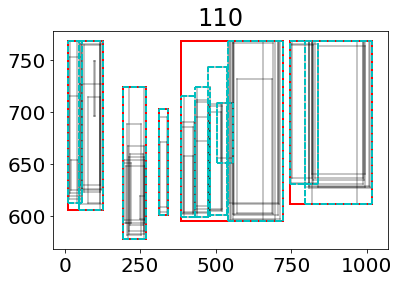

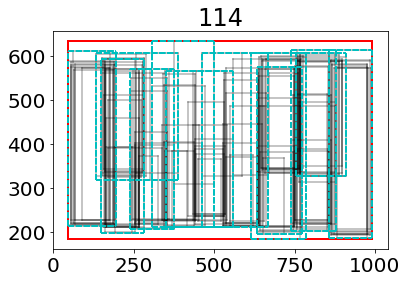

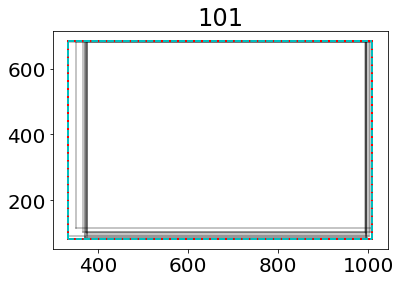

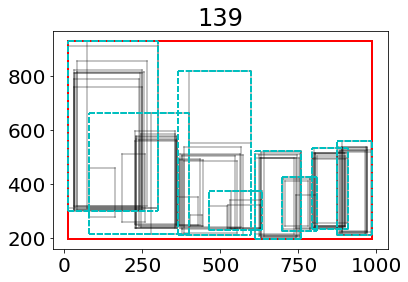

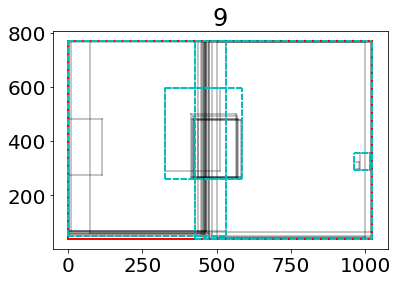

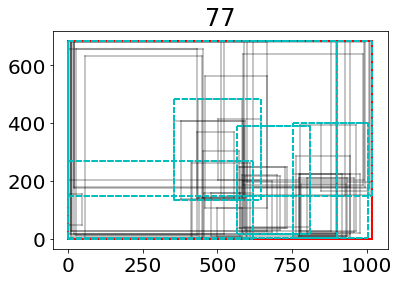

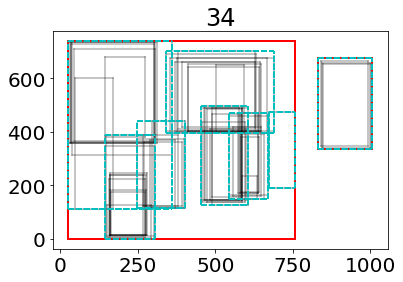

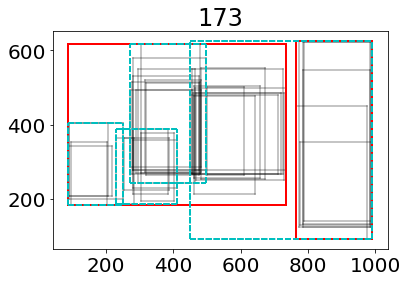

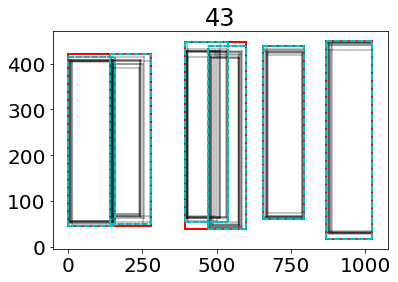

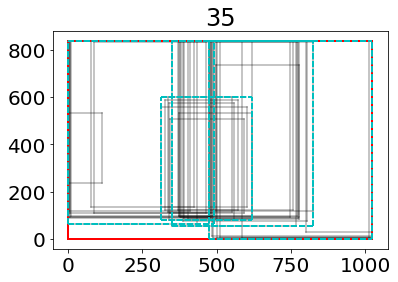

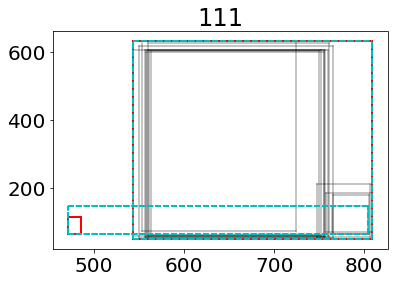

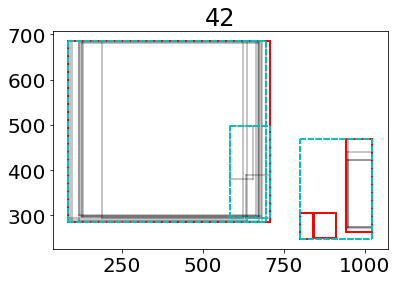

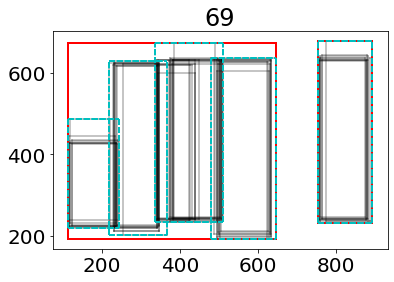

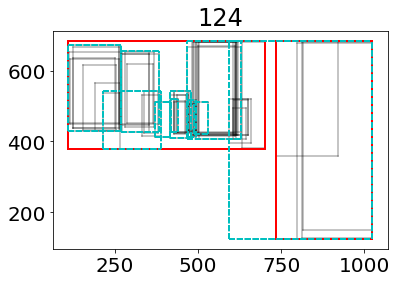

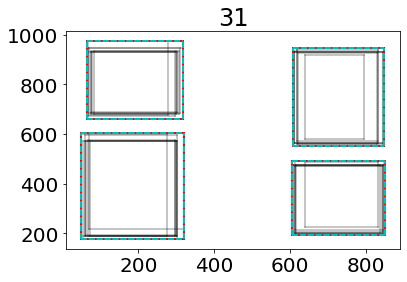

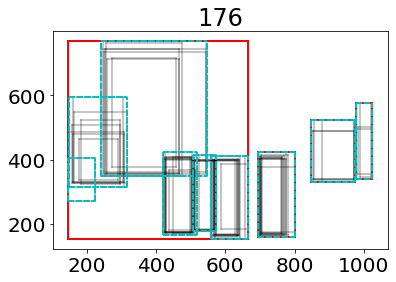

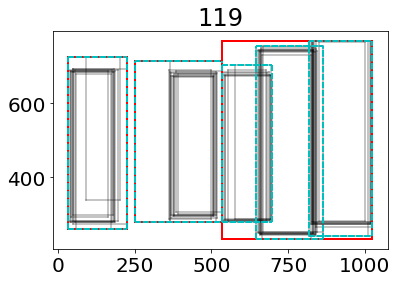

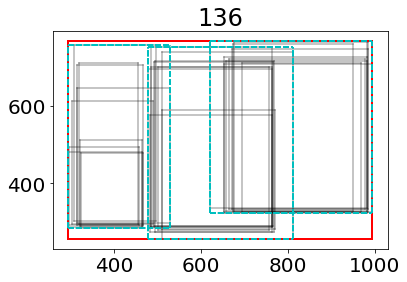

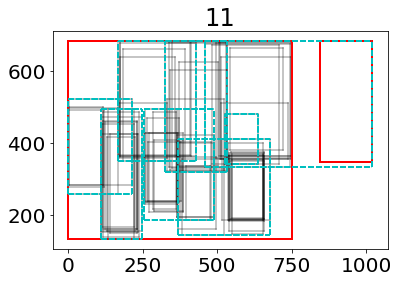

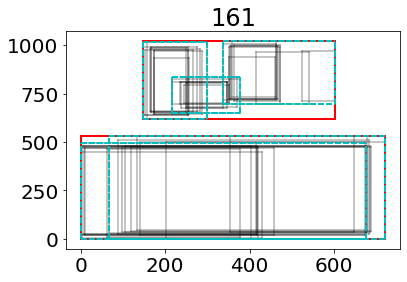

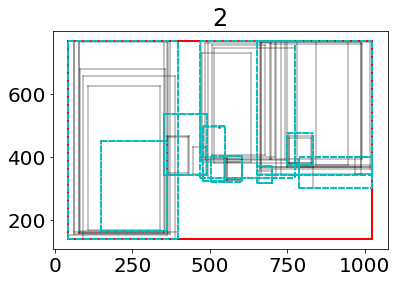

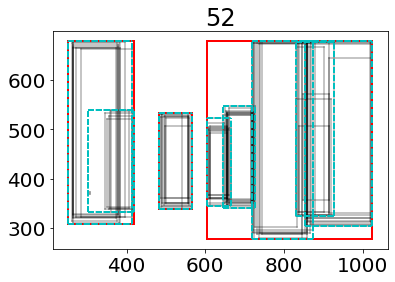

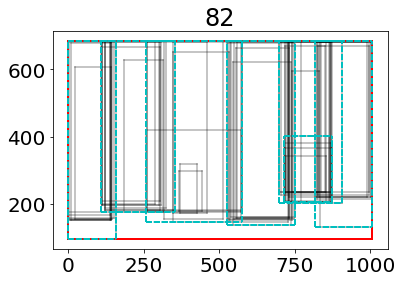

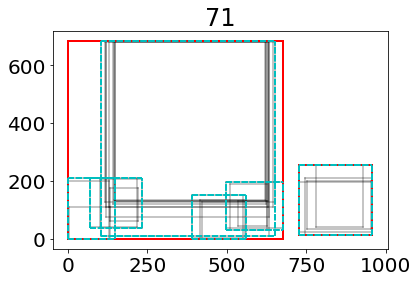

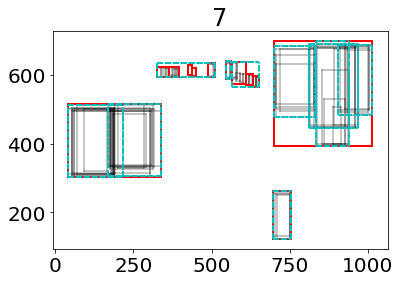

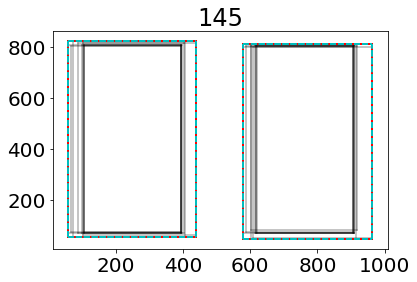

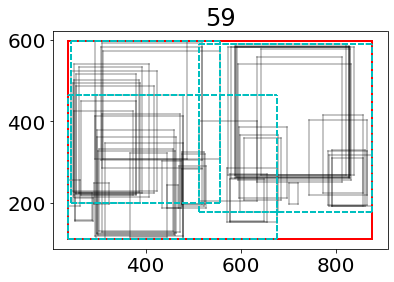

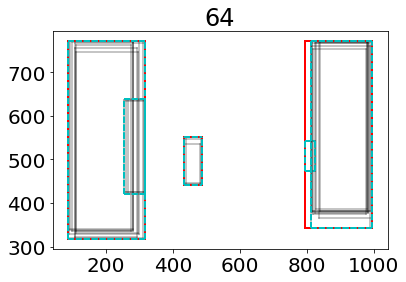

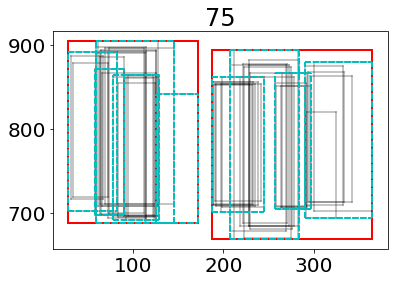

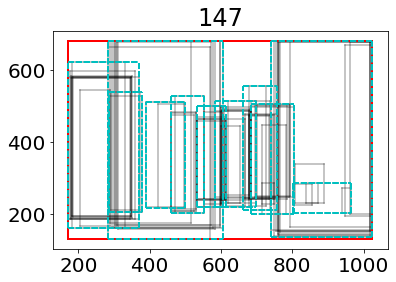

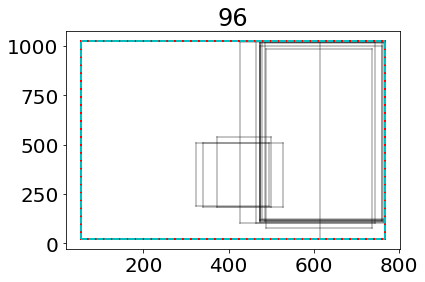

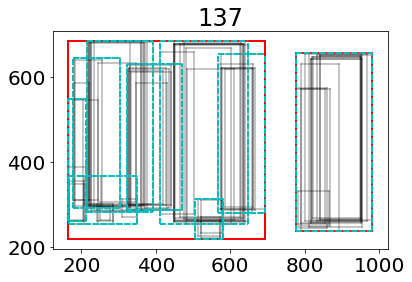

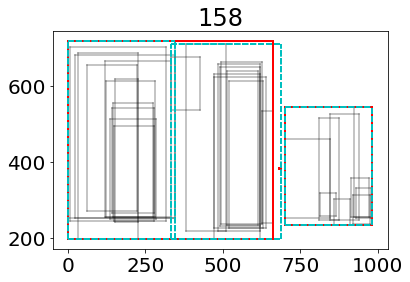

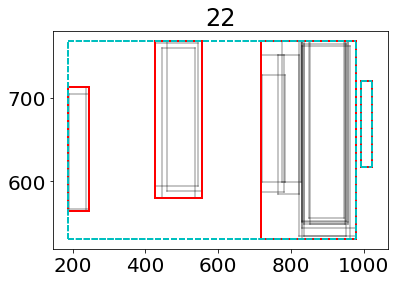

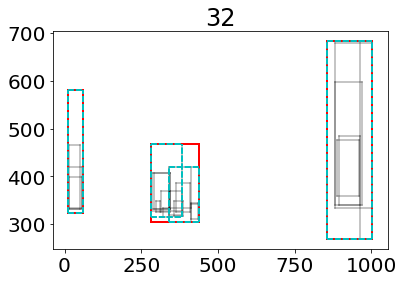

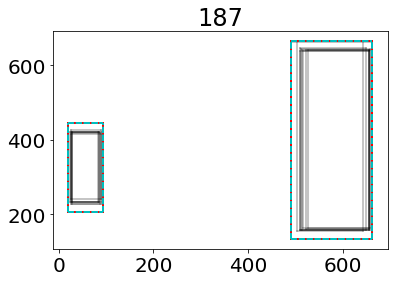

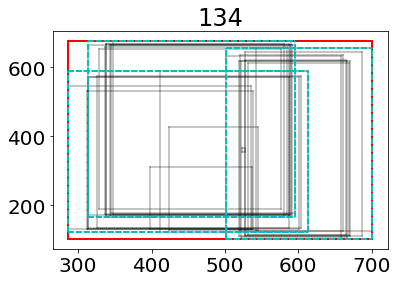

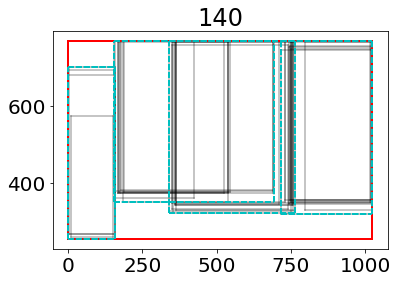

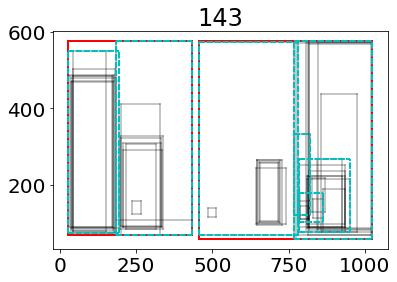

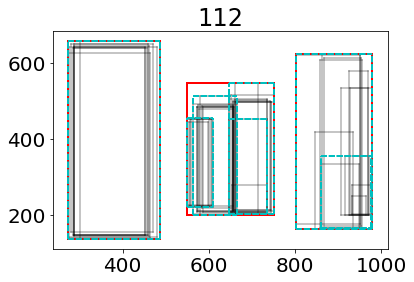

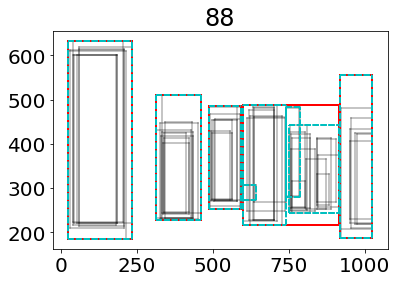

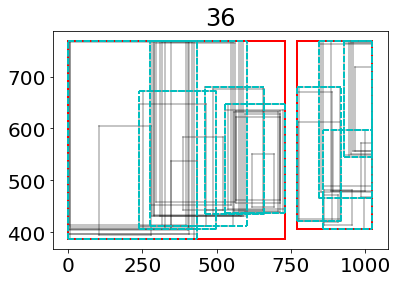

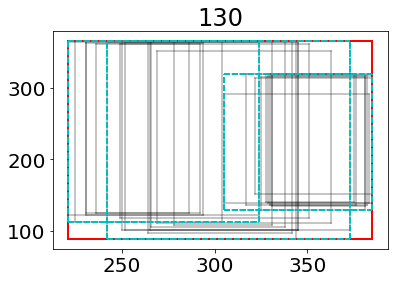

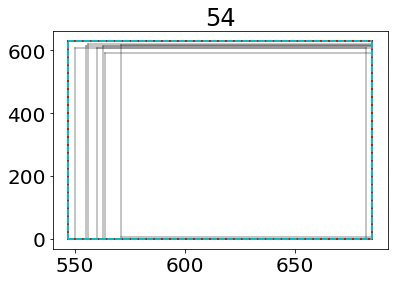

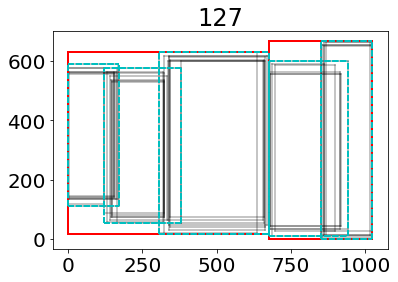

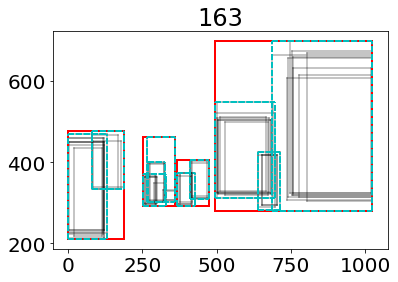

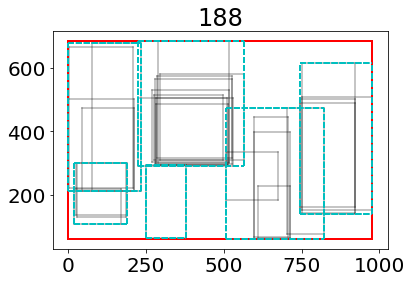

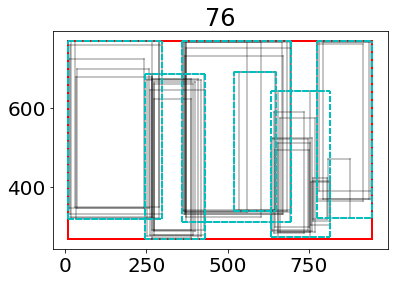

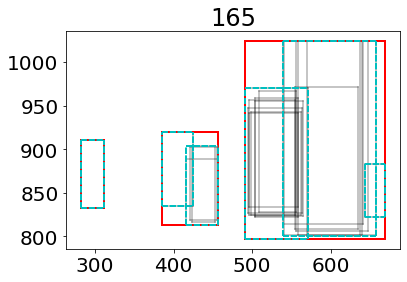

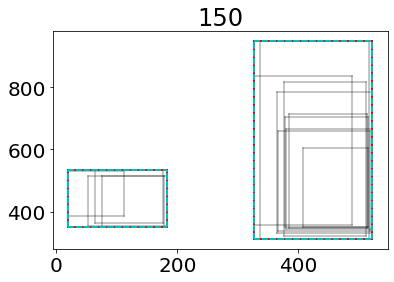

In [265]:
for item in granno_df.origItemID.unique()[:100]:
    idf = granno_df[granno_df.origItemID==item]
    idf_orc = granno_df_orc[granno_df_orc.origItemID==item]
    for vr in [vr for annotation in idf["annotation"] for vr in annotation]:
        plot_vectorrange(vr, color="k")
    for vr in idf["newItemVR"].values:
        plot_vectorrange(vr, color="r", alpha=1)
    for vr in idf_orc["newItemVR"].values:
        plot_vectorrange(vr, color="c--", alpha=1)
    plt.title(idf["origItemID"].values[0])
    plt.show()

In [261]:

# def plot_grannos(data):
#     for vr in [vr for annotation in data["annotation"] for vr in annotation]:
#         plot_vectorrange(vr)
#     for vr in data["newItemVR"].values:
#         plot_vectorrange(vr, color="k", alpha=1)
#     plt.title(data["origItemID"].values[0])
#     plt.show()

# granno_df.iloc[:400].groupby("origItemID").apply(plot_grannos)
    

In [266]:
# import granularity
# annodf = bb_experiment.annodf
# item_colname = bb_experiment.item_colname
# label_colname = bb_experiment.label_colname
# oracle_golddict = bb_experiment.golddict

# for item_id in annodf[item_colname].unique():
#     idf = annodf[annodf[item_colname] == item_id]
#     vectorranges = [vr for annotation in idf[label_colname].values for vr in annotation]
    
#     if oracle_golddict is not None:
#         try:
#             gold_vrs = [vr for vr in oracle_golddict.get(item_id)]
#             orbuckets = {}
#             for vr in vectorranges:
#                 vr_orbucket = np.argmin([granularity.dist_center(vr, gold_vr) for gold_vr in gold_vrs])
#                 orbuckets.setdefault(vr_orbucket, []).append(vr)
#             unranges = []
#             for orbucket in orbuckets.values():
#                 minstart = np.min([vr.start_vector for vr in orbucket], axis=0)
#                 maxend = np.max([vr.end_vector for vr in orbucket], axis=0)
#                 unranges.append(VectorRange(minstart, maxend))
#         except:
#             continue


In [267]:
# granno_df

In [268]:
gran_exp = experiments.RealExperiment(bb_experiment.eval_fn, "annotation", "newItemID", "uid")
gran_exp.setup(granno_df, merge_index="origItemID")

  0%|          | 2/544 [00:00<00:27, 19.91it/s]/Users/alexbraylan/Tools/annotationmodeling/mas/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/alexbraylan/Tools/annotationmodeling/mas/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 544/544 [00:22<00:00, 24.06it/s]


In [269]:
gran_exp.train(iter=0)

Pickled model loaded


In [270]:
gmean_preds = gran_exp.annodf.groupby("newItemID").agg({"annotation":merge_mean})["annotation"].to_dict()
gran_exp.register_baseline("MEAN MERGE", gmean_preds)

In [271]:
gran_exp.test_merged(bb_experiment.golddict)

BEST AVAILABLE USER
0.035640058565042806 0.6614145579304903
t-test Ttest_relResult(statistic=-93.51155653578633, pvalue=0.0)
z-score 2.9585747193734475
baseline below thresh 0.0
model below thresh 0.0
BEST HONEYPOT USER
0.035640058565042806 0.0
t-test Ttest_relResult(statistic=13.616938352439082, pvalue=7.397387736652117e-39)
z-score -0.43082086382954715
baseline below thresh 0.0
model below thresh 0.0
SMALLEST AVERAGE DISTANCE
0.035640058565042806 0.6789282860056696
t-test Ttest_relResult(statistic=-100.01298200766395, pvalue=0.0)
z-score 3.164270718387502
baseline below thresh 0.0
model below thresh 0.0
HEURISTIC
0.035640058565042806 0.6804384449790163
t-test Ttest_relResult(statistic=-102.87791625322632, pvalue=0.0)
z-score 3.2549132266035246
baseline below thresh 0.0
model below thresh 0.0
MULTIDIMENSIONAL ANNOTATION SCALING
0.035640058565042806 0.0
t-test Ttest_relResult(statistic=13.616938352439082, pvalue=7.397387736652117e-39)
z-score -0.43082086382954715
baseline below thresh 

Pickled model loaded
BEST AVAILABLE USER
0.5725106002025941 0.6478674335488478 -> 0.6614145579304903
t-test Ttest_relResult(statistic=-13.102480595393905, pvalue=2.6027481218193495e-36)
z-score 0.41454414071033624
baseline below thresh 0.0
model below thresh 0.0
SMALLEST AVERAGE DISTANCE
0.5725106002025941 0.6654911488712765 -> 0.6789282860056696
t-test Ttest_relResult(statistic=-17.271168712318897, pvalue=1.0969908928966314e-58)
z-score 0.5464355959762623
baseline below thresh 0.0
model below thresh 0.0
HEURISTIC
0.5725106002025941 0.6675550538645012 -> 0.6804384449790163
t-test Ttest_relResult(statistic=-17.812797841150342, pvalue=7.508160960624522e-62)
z-score 0.5635719832550233
baseline below thresh 0.0
model below thresh 0.0
MEAN MERGE
0.5725106002025941 0.18242194098124412 -> 0.38408267896477766
t-test Ttest_relResult(statistic=52.014827416235526, pvalue=1.479721504546428e-286)
z-score -1.6456763113268749
baseline below thresh 0.0
model below thresh 0.0
ORACLE
0.5725106002025941 0.745156316020659
t-test Ttest_relResult(statistic=-33.50078195375674, pvalue=1.5306697888638054e-165)
z-score 1.0599178351789744
baseline below thresh 0.0
model below thresh 0.0

In [272]:
gran_exp_orc = experiments.RealExperiment(bb_experiment.eval_fn, "annotation", "newItemID", "uid")
gran_exp_orc.setup(granno_df_orc, merge_index="origItemID")
gran_exp_orc.train(iter=0)
gmean_preds_orc = gran_exp_orc.annodf.groupby("newItemID").agg({"annotation":merge_mean})["annotation"].to_dict()
gran_exp_orc.register_baseline("MEAN MERGE", gmean_preds_orc)
gran_exp_orc.test_merged(bb_experiment.golddict)

  0%|          | 0/1172 [00:00<?, ?it/s]/Users/alexbraylan/Tools/annotationmodeling/mas/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/alexbraylan/Tools/annotationmodeling/mas/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 1172/1172 [00:47<00:00, 24.79it/s]


Pickled model loaded
BEST AVAILABLE USER
0.05968479057477516 0.6989384510745585
t-test Ttest_relResult(statistic=-113.28714520625097, pvalue=0.0)
z-score 3.584246656282916
baseline below thresh 0.0
model below thresh 0.0
BEST HONEYPOT USER
0.05968479057477516 0.0
t-test Ttest_relResult(statistic=20.775199837544097, pvalue=5.774597077723088e-80)
z-score -0.6572982346387
baseline below thresh 0.0
model below thresh 0.0
SMALLEST AVERAGE DISTANCE
0.05968479057477516 0.7309927637484295
t-test Ttest_relResult(statistic=-135.01397103534117, pvalue=0.0)
z-score 4.271653004883013
baseline below thresh 0.0
model below thresh 0.0
HEURISTIC
0.05968479057477516 0.7283926025539204
t-test Ttest_relResult(statistic=-134.08560641426794, pvalue=0.0)
z-score 4.2422808481141665
baseline below thresh 0.0
model below thresh 0.0
MULTIDIMENSIONAL ANNOTATION SCALING
0.05968479057477516 0.0
t-test Ttest_relResult(statistic=20.775199837544097, pvalue=5.774597077723088e-80)
z-score -0.6572982346387
baseline below

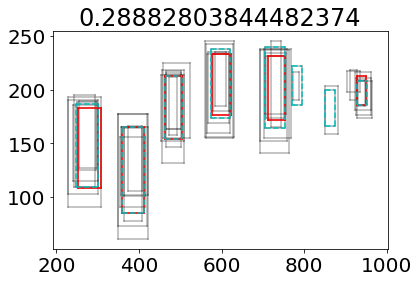

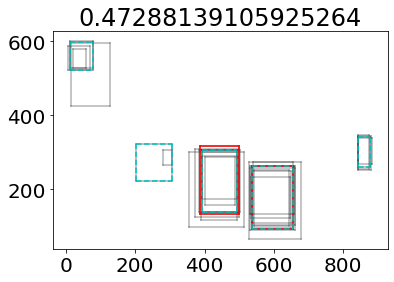

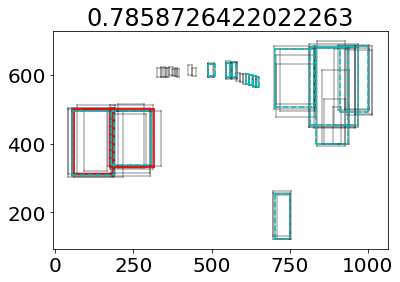

[([59.0, 311.0], [183.0, 502.0]), ([176.0, 331.0], [316.0, 501.0])] 
vs
 [([54.0, 308.0], [188.0, 495.0]), ([179.0, 338.0], [305.0, 495.0]), ([489.0, 596.0], [510.0, 632.0]), ([545.0, 594.0], [560.0, 635.0]), ([567.0, 594.0], [580.0, 638.0]), ([612.0, 575.0], [620.0, 603.0]), ([620.0, 571.0], [632.0, 600.0]), ([634.0, 568.0], [643.0, 597.0]), ([642.0, 566.0], [653.0, 593.0]), ([702.0, 123.0], [753.0, 254.0]), ([704.0, 507.0], [829.0, 675.0]), ([814.0, 454.0], [968.0, 680.0]), ([836.0, 399.0], [936.0, 677.0]), ([912.0, 492.0], [1002.0, 685.0])]
dist= 0.7858726422022263


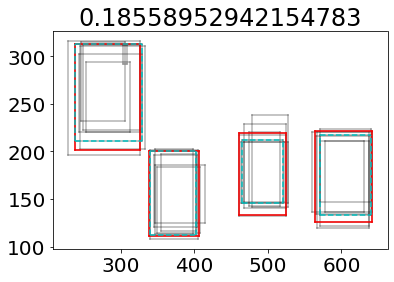

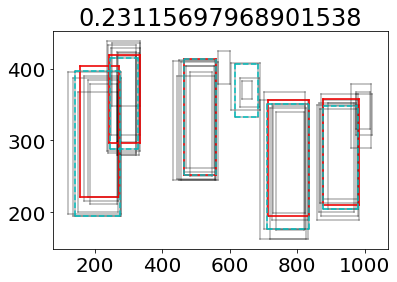

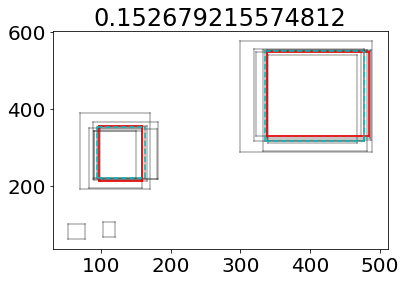

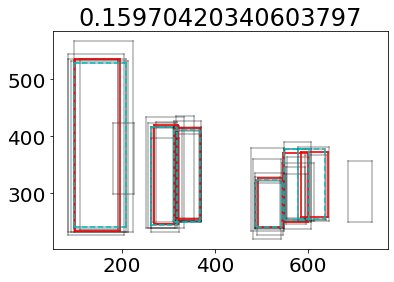

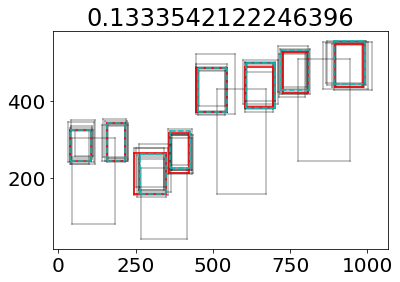

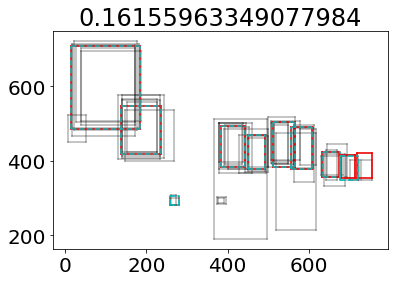

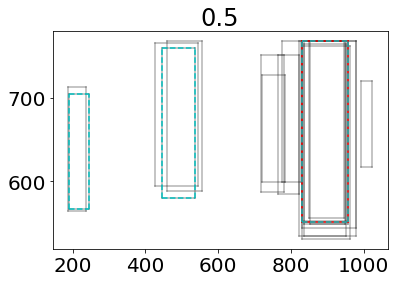

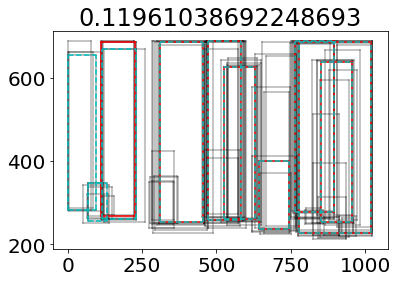

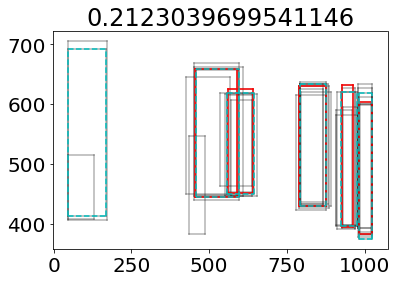

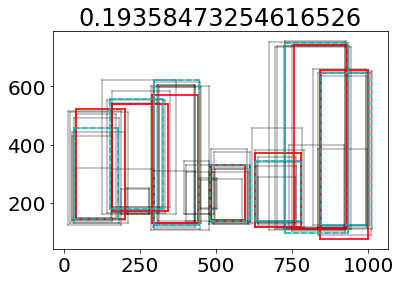

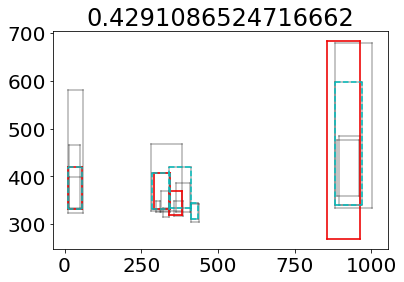

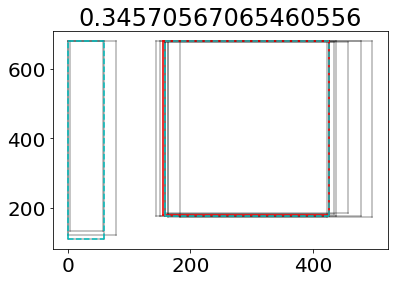

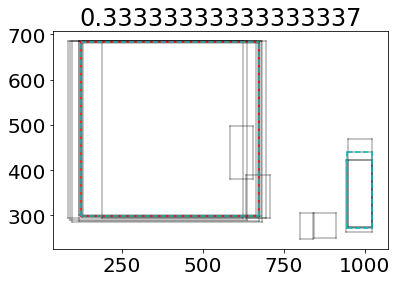

In [192]:
for i in range(len(bb_experiment.annodf))[:50]:
    sad_orig = bb_experiment.sad_preds.get(i)
    sad_gran = gran_exp.sad_preds.get(i)
    dist = bb_experiment.distance_fn(sad_orig, sad_gran)
    if dist < 0.1:
        continue
    
    idf = bb_experiment.annodf[bb_experiment.annodf["item"]==i]
    
    vrs = [vr for annotation in idf["annotation"] for vr in annotation]
    for vr in vrs:
        plot_vectorrange(vr, "k")
    for vr in sad_orig:
        plot_vectorrange(vr, "r", 1)
    for vr in sad_gran:
        plot_vectorrange(vr, "c--", 1)
    plt.title(dist)
    plt.show()
    if dist > 0.5:
        print(sorted(sad_orig), "\nvs\n", sorted(sad_gran))
        sdist = bb_experiment.distance_fn(sorted(sad_orig), sorted(sad_gran))
        print("dist=", sdist)
